In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel, eigh
from matplotlib import pyplot as plt
from matplotlib import style

## Data fetching and cleaning for analysis.

In [24]:
flag = np.zeros(1602, dtype = int)
flag

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
xmeas = np.asarray(pd.read_csv('/content/drive/MyDrive/TE-DATASET/2SA2xmv6_twentyeight_data_1.csv', usecols=[9], header=None))

In [26]:
xmeas

array([[0.19833],
       [0.19506],
       [0.19536],
       ...,
       [0.2294 ],
       [0.22763],
       [0.2299 ]])

In [27]:
X_train_data = xmeas[:1500] # For training 
X_theta = xmeas[1000:3500] # For threshold calculation
X_test = xmeas[2700:] # For detection

In [28]:
X_train_data.shape

(1500, 1)

## Embedding (Creating Lag Covariance Matrix)

In [29]:
N = len(X_train_data)
#L = N // 2
L=500
X_train = hankel(X_train_data[:L],X_train_data[L-1:]) # Creating trajectory matrix

In [30]:
X_train.shape

(500, 1001)

## Singular Value Decomposition of Log Covariance matrix (Trajectory Matrix above)

Text(0.5, 0, 'Cardinal Number of Eigen value ->')

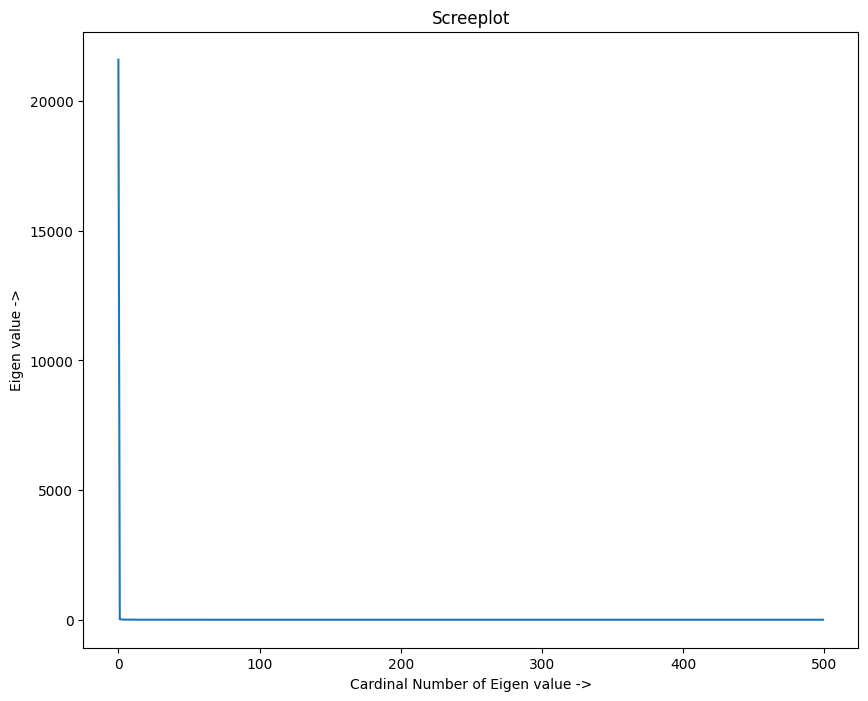

In [31]:
eigenValues, eigenVectors = eigh(np.matmul(X_train, X_train.T))
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# Sree plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(eigenValues)
ax.set_title("Screeplot")
ax.set_ylabel("Eigen value ->")
ax.set_xlabel("Cardinal Number of Eigen value ->")

## Projection onto signal subspace

In [32]:
# From the above scree plot, it is seen that the first eigen value is more 
# significant and the other eigen values are close to zero. Thus we choose r as 1
# and then we compute the U for projection and centroid in the signal subspace
r = 1
# Extracted Training signals
U, Sigma, V = np.linalg.svd(X_train)
V = V.T
# d = np.linalg.matrix_rank(X_train)
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,r)] )
X_train_extracted = X_elem.sum(axis=0)
X_train_extracted_data = np.asarray(list(X_train_extracted[:,0]) + list(X_train_extracted[:,-1]))
#print(U, U.shape)

U = eigenVectors[:,:r] # r as statistical dimension
#K = eigenVectors[:,:r]
print("\n\n",X_train.shape, X_train_extracted.shape, X_elem.shape)
UT = U.T
pX = np.matmul(UT,X_train_extracted)
centroid = np.mean(pX, axis=1)
print(UT.shape,pX.shape, centroid)
centroid = centroid[:,np.newaxis]
print(centroid.shape, centroid)



 (500, 1001) (500, 1001) (1, 500, 1001)
(1, 500) (1, 1001) [-4.64432596]
(1, 1) [[-4.64432596]]


## Distance Tracking and Threshold Calculation

In [33]:
# Calculating the departure threshold in signal subspace using centroid and UT

#For training phase
Xtrg = hankel(X_train_data[:L], X_train_data[L-1:])
pXtrg = np.matmul(UT,Xtrg)
#print(centroid,pXtrg.shape, pXtrg)
dtrg_matrix = centroid - pXtrg
dtrg_scores = np.linalg.norm(dtrg_matrix, axis=0, ord=2)
print(type(dtrg_scores))

# For Validation phase and threshold calculation
Xt = hankel(X_theta[:L],X_theta[L-1:])
pXt = np.matmul(UT,Xt)
dt_matrix = centroid - pXt
dt_scores = np.linalg.norm(dt_matrix, axis=0, ord=2)
print(dt_matrix.shape, dt_scores.shape)
# d_scores = np.asarray([np.matmul(d_matrix[:,i].T, d_matrix[:,i]) for i in range(d_matrix.shape[1])])
dt_theta = np.max(dt_scores)
dt_theta


<class 'numpy.ndarray'>
(1, 2001) (2001,)


0.13244027882139342

## Testing Phase

In [34]:
Xj = hankel(X_test[:L],X_test[L-1:])

In [35]:
L

500

In [36]:
Xj.shape

(500, 1602)

In [37]:
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
# dj_scores = [np.matmul(dj_matrix[:,i].T, dj_matrix[:,i]) for i in range(dj_matrix.shape[1])]
dj_scores = np.asarray(dj_scores)
np.max(dj_scores)

0.4423601778822279

## Plotting and Visualizing

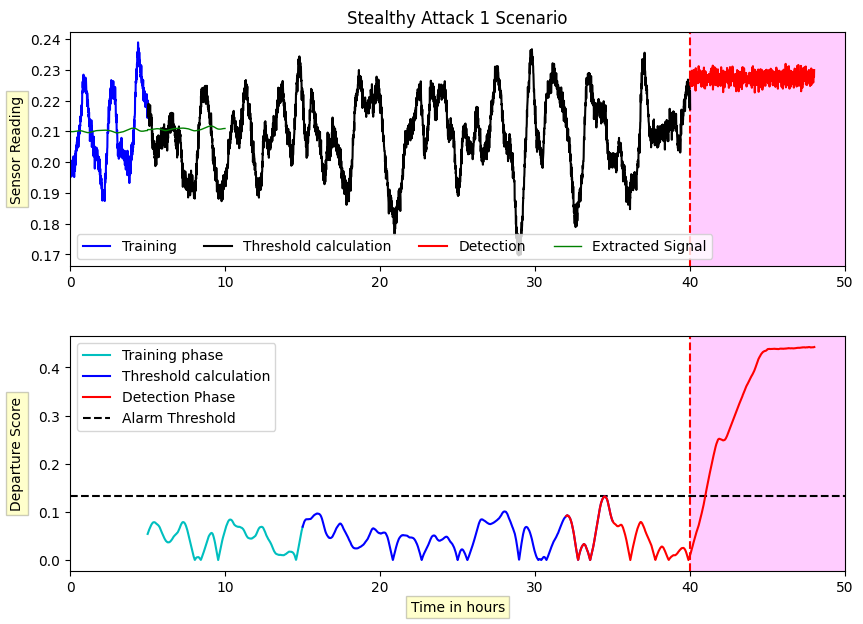

In [38]:
#Testing Plots and Subplots
style.use('default')
box = dict(facecolor='yellow', pad=3, alpha=0.2)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_xlim(0,5000)
ax2.set_xlim(0,5000)
# ax2.set_ylim(0,10)

plt.subplots_adjust(hspace =0.3)

xlables = list(range(0,5000,10)) # for both plots

# Plotting signal reading
xmeasx_1 = list(range(501))
xmeasx_2 = list(range(501, 4001))
xmeasx_3 = list(range(4001,len(xmeas)))
ax1.plot(xmeasx_1, xmeas[:501] ,'b', label='Training') # Plot of Training Data
ax1.plot(xmeasx_2, xmeas[501:4001] ,'k', label='Threshold calculation') # Plot of Threshold Determination Data
ax1.plot(xmeasx_3, xmeas[4001:] ,'r', label='Detection') # Plot of Detection Phase
ax1.plot(X_train_extracted_data, 'g', linewidth=1, label='Extracted Signal' )
ax1.set_xticklabels(xlables)
ax1.title.set_text('Stealthy Attack 1 Scenario')
ax1.set_ylabel('Sensor Reading', bbox=box)
ylim = list(ax1.get_ylim())
ax1.vlines(4000,ylim[0],ylim[1],linestyles='dashed', colors='r')
X = np.array([[4000,5000],[4000,5000]])
Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
C = np.array([[4000,4500]])
ax1.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
ax1.legend(loc='best', ncol=4)


# Plotting departure score
dy = dtrg_scores
dx = list(range(L,len(dy)+L))
ax2.plot(dx, dy, 'c', label='Training phase')
dy = dt_scores
dx = list(range(1500,len(dy)+1500))
ax2.plot(dx, dy, 'b', label='Threshold calculation')
dy = dj_scores
dx = list(range(3200,len(dy)+3200))
ax2.plot(dx, dy, 'r', label='Detection Phase')
ylim = list(ax2.get_ylim())
ax2.vlines(4000,ylim[0],ylim[1],linestyles='dashed', colors='r')
ax2.set_xticklabels(xlables)
ax2.hlines(dt_theta,0,5000,linestyles='dashed', label='Alarm Threshold')
ax2.set_xlabel('Time in hours', bbox=box)
ax2.set_ylabel('Departure Score', bbox=box)

X = np.array([[4000,5000],[4000,5000]])
Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
C = np.array([[4000,4500]])
ax2.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
ax2.legend(loc='upper left')
fig.align_ylabels([ax1,ax2])

In [39]:
#print(flag)
for i in range(800,len(flag)):
  if dj_scores[i] > dt_theta:
    flag[i] = 1
for j in range(800):
  if dj_scores[j] <= dt_theta:
    flag[j] = 1
flag

array([1, 1, 1, ..., 1, 1, 1])

In [40]:
cnt =0
print(len(flag))
for k in range(len(flag)):
  #print(k)
  if flag[k]==0:
    #print(k)
    cnt+=1
print(cnt)

1602
98


In [41]:
FP = 0
FN = 0
for _ in range(len(flag)):
  if _ <800:
    if flag[_]==0:
      FP += 1
  else:
    if flag[_]==0:
      FN += 1
TP = 800-FP
TN = 802-FN

In [42]:
print(FP, FN, TN, TP)
prec = TP/(TP+FP)
rec = TP/(TP+FN)
acc = (TP+TN)/(TP+FP+TN+FN)
print("Precision:",prec, "\nRecall:", rec, "\nAccuracy:", acc)

0 98 704 800
Precision: 1.0 
Recall: 0.89086859688196 
Accuracy: 0.9388264669163545
